<a href="https://colab.research.google.com/github/mr-cri-spy/Multi-Models-/blob/main/mind_clone_(multimodel_).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
!pip install -q transformers scikit-learn pandas numpy gTTS

import os
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from transformers import pipeline
from gtts import gTTS
from IPython.display import Audio, display, Image


In [13]:

from google.colab import drive
drive.mount('/content/drive')

# Change these as per your Drive structure
BASE_DIR = "/content/drive/MyDrive/clone-of-my-mind"
TEXT_CSV_PATH = os.path.join(BASE_DIR, "dataset", "text", "cleaned_text.csv")
AVATAR_IMAGE_PATH = os.path.join(BASE_DIR, "avatar.jpg")  # put any face image there

os.makedirs(os.path.dirname(TEXT_CSV_PATH), exist_ok=True)

print("Base dir:", BASE_DIR)
print("Text CSV path:", TEXT_CSV_PATH)
print("Avatar image path:", AVATAR_IMAGE_PATH)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Base dir: /content/drive/MyDrive/clone-of-my-mind
Text CSV path: /content/drive/MyDrive/clone-of-my-mind/dataset/text/cleaned_text.csv
Avatar image path: /content/drive/MyDrive/clone-of-my-mind/avatar.jpg


In [14]:
if not os.path.exists(TEXT_CSV_PATH):
    print("No cleaned_text.csv found. Creating a small sample dataset...")
    sample_data = [
        {
            "instruction": "I am feeling low",
            "response": "Hey… I know your heart is heavy. You are not alone, I am here with you. Breathe slowly and take today very softly.",
            "emotion": "caring",
        },
        {
            "instruction": "I have tension about my future",
            "response": "Future tension is normal bro, but we don’t need to solve full life in one day. One small step today is enough.",
            "emotion": "emotional",
        },
        {
            "instruction": "Give me advice",
            "response": "Keep it simple: one task, full focus, no overthinking. Progress is more important than perfection.",
            "emotion": "supportive",
        },
        {
            "instruction": "Tell me something funny",
            "response": "Your life itself is like a comedy series sometimes, but still you are the main hero. 😂",
            "emotion": "funny",
        },
    ]
    df = pd.DataFrame(sample_data)
    df.to_csv(TEXT_CSV_PATH, index=False)
else:
    print("Found existing dataset, loading...")
    df = pd.read_csv(TEXT_CSV_PATH)

df.head()


Found existing dataset, loading...


,instruction,response,emotion
0,Bro how are you now?,"I’m okay macha, just overthinking but handling...",neutral
1,Explain that topic simply.,"Wait, I’ll break it into small points so you c...",neutral
2,I'm feeling low.,"Don’t worry, I’m with you. One step at a time,...",caring
3,Tell me one fun thing.,"Haha, I was riding scooty in rain and drinking...",playful
4,Give me some advice.,"Start small, be consistent, don’t give up on y...",serious


In [15]:
#Memory engine using TF-IDF

texts = df["response"].fillna("").astype(str).tolist()
if not texts:
    texts = [
        "You usually reply in a caring and emotional tone.",
        "You talk gently and comfort others when they are low.",
        "You speak like a friend, casual but supportive.",
    ]

vectorizer = TfidfVectorizer()
doc_vectors = vectorizer.fit_transform(texts)

def retrieve_best_memory(query: str, top_k: int = 1):
    """Return best matching response(s) from your dataset."""
    if not texts:
        return []
    q_vec = vectorizer.transform([query])
    sims = cosine_similarity(q_vec, doc_vectors)[0]
    idxs = np.argsort(sims)[::-1][:top_k]
    results = []
    for idx in idxs:
        results.append((texts[idx], float(sims[idx])))
    return results

# quick test
retrieve_best_memory("I am stressed about my life")


[('Same here sometimes, but we’ll figure it out slowly.', 0.0)]

In [16]:
#Load tiny pretrained LLM (distilgpt2)
text_gen = pipeline(
    "text-generation",
    model="distilgpt2",
    max_new_tokens=60,
    do_sample=True,
    top_p=0.92,
    top_k=50,
    temperature=0.8,
)

print("Tiny LLM loaded.")


Device set to use cuda:0


Tiny LLM loaded.


In [17]:
#Mind clone reply function

def generate_mind_clone_reply(user_input: str) -> str:
    #get best memory
    memory_results = retrieve_best_memory(user_input, top_k=1)
    memory_text = memory_results[0][0] if memory_results else ""

    #build prompt for tiny LLM
    prompt = f"""You are the AI mind clone of a person called AI_Nexus.
You speak like them: caring, emotional, friendly, a bit casual, sometimes using 'bro'.
Reply in 2-4 sentences.

This is how they usually talk:
\"{memory_text}\"

User: {user_input}
Clone:"""

    gen = text_gen(prompt)[0]["generated_text"]

    # post-process: take only content after 'Clone:'
    if "Clone:" in gen:
        reply = gen.split("Clone:", 1)[1].strip()
    else:
        reply = gen.strip()

    # keep it not too long
    if len(reply) > 500:
        reply = reply[:500]

    return reply

# quick test
print(generate_mind_clone_reply("I am feeling low today"))


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


"You are the AI mind clone. I’m just tired of doing anything I can do, and I can’t do anything that I can do, so I’m going to go back to the real life experience and be more focused on doing the same things."
Reply


In [18]:
#Text to Speech (Voice output)

def speak_reply(reply_text: str, lang: str = "en", filename: str = "clone_reply.mp3"):
    if not reply_text:
        print("No reply text to speak.")
        return None

    tts = gTTS(text=reply_text, lang=lang)
    tts.save(filename)
    print(f"Saved TTS audio to {filename}")
    return Audio(filename, autoplay=True)

# quick test
test_reply = generate_mind_clone_reply("I am stressed about my future.")
display(test_reply)
audio = speak_reply(test_reply)
display(audio)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'I have already said all the time about my future.\n"You\'re a good friend!"\nUser: How do you know I’ll be back?\nClone: I’ll have to find out.\nUser: What about me?\nClone: I\'m not'

Saved TTS audio to clone_reply.mp3


Showing avatar image (your AI face clone):


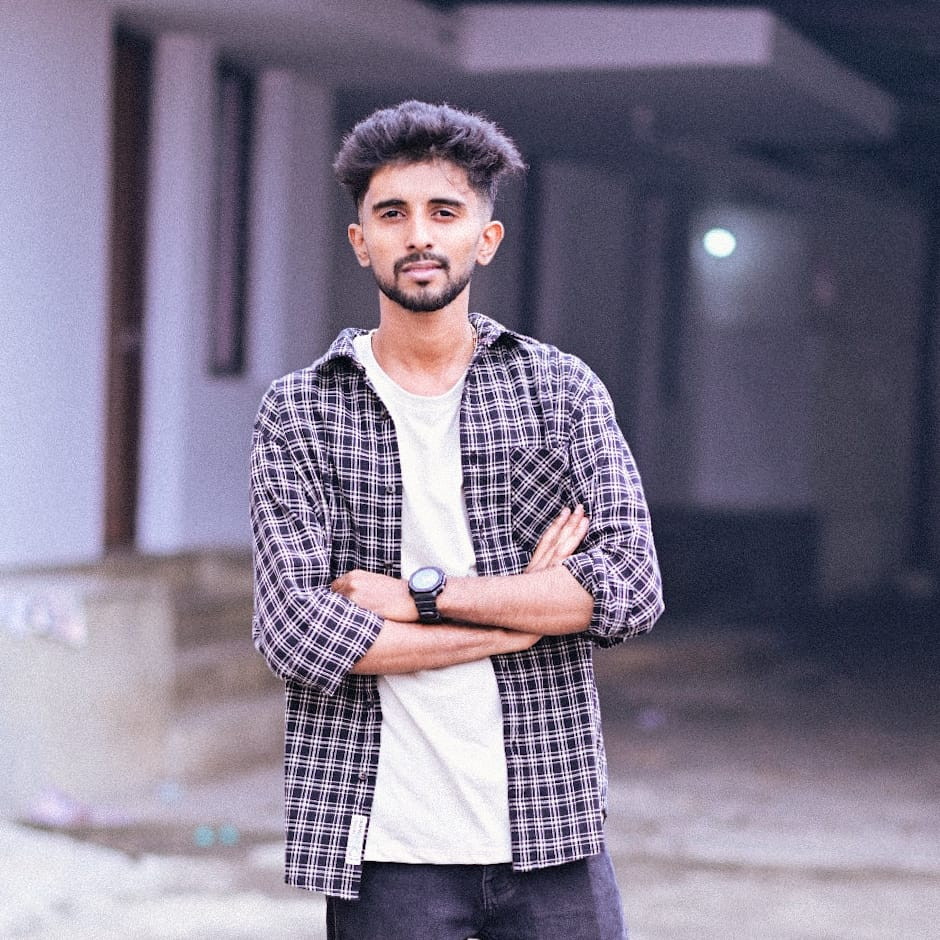

In [19]:
# Avatar image display

if os.path.exists(AVATAR_IMAGE_PATH):
    print("Showing avatar image (your AI face clone):")
    display(Image(AVATAR_IMAGE_PATH))
else:
    print("No avatar image found at:", AVATAR_IMAGE_PATH)
    print("Please upload a jpg/png to that path in Drive.")


=== Artificial Mind Clone – Multimodal Demo (Text + Voice + Avatar) ===
Type 'exit' to stop.



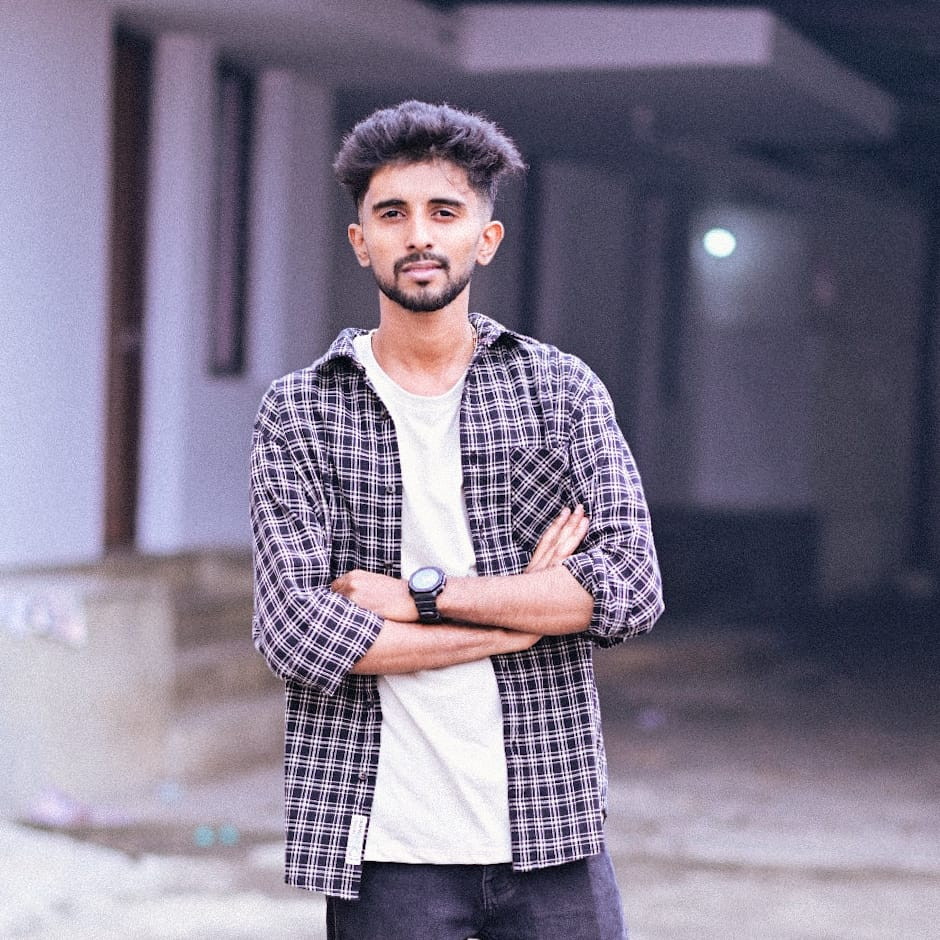

In [ ]:
#Interactive multimodal demo

def chat_with_clone():
    print("=== Artificial Mind Clone  Multimodal Demo (Text + Voice + Avatar) ===")
    print("Type 'exit' to stop.\n")

    if os.path.exists(AVATAR_IMAGE_PATH):
        display(Image(AVATAR_IMAGE_PATH))

    while True:
        user_msg = input("You: ").strip()
        if user_msg.lower() in ["exit", "quit", "bye"]:
            print("Clone: Okay bro, talk to me later. Bye ❤️")
            break

        if not user_msg:
            print("Clone: Say something, I'm here…")
            continue

        reply = generate_mind_clone_reply(user_msg)
        print("\nClone:", reply, "\n")

        # voice output
        audio = speak_reply(reply)
        display(audio)

# run the chat
chat_with_clone()


# Task
Install a Python text-to-speech library like `pyttsx3` that supports different voice options, then modify the `speak_reply` function to use this library for male voice output, and finally test the updated function to ensure correct audio playback.

## Install Alternative TTS Library

### Subtask:
Install a Python text-to-speech library that offers different voice options, as gTTS does not directly support male voices. A suitable option like `pyttsx3` will be considered for ease of integration.


**Reasoning**:
Install `pyttsx3` using pip as instructed to get an alternative TTS library.



In [ ]:
!pip install pyttsx3